TO DEMEAN OR NOT TO DEMEAN?

author: [@sparshsah](https://github.com/sparshsah)

In my writeup here [https://github.com/sparshsah/foggy-demo/blob/main/demo/stats/bias-variance-risk.ipynb.pdf](https://github.com/sparshsah/foggy-demo/blob/main/demo/stats/bias-variance-risk.ipynb.pdf), I show that, for small-enough Sharpes or small-enough sample sizes, a demeaned volatility estimator will be MSE-worse than a non-demeaned volatility estimator. There I gave a simple example. Now I want to interpret this result in its natural home: Financial risk modeling.

In [30]:
import sys
sys.path.append("../../../foggy-lib/util/")
del sys

import pandas as pd
import numpy as np
import foggy_pylib.core as fc
import foggy_pylib.fin as ff

# How does the crossover threshold decay with sample size?

See the paper quoted above to get the full details of what I'm simplifying here. But the upshot based on the plot below is:

Even with 100 years of daily returns data, the you'd still do MSE-better with the non-demeaned estimator unless your data-generating process's Sharpe was above $0.12$ -- which actually surprised me, as I'd have expected that by then you'd have so much data that you might as well use the demeaned version unless you had literally a zero Sharpe.

Said another way: There are commodities out there whose Sharpes are around $0.10$. This result says that even if you had high-quality daily returns data going back to 1922, you should use the non-demeaned volatility estimator to get lower expected squared estimation error.

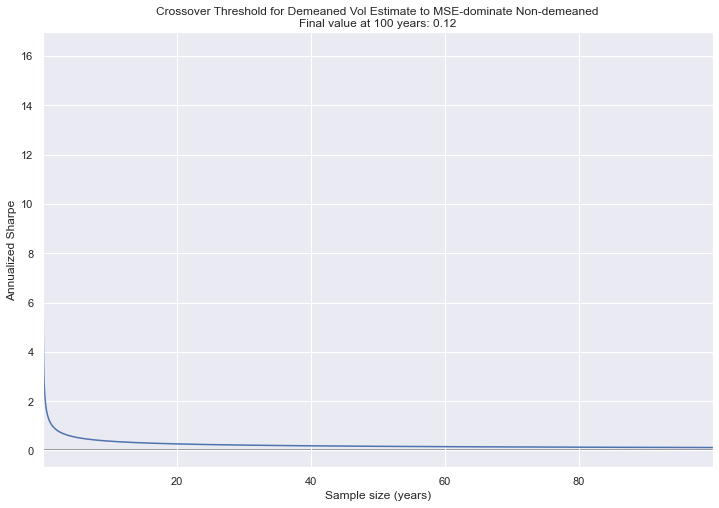

In [31]:
MIN_T_DAYS = 2  # need at least 2 data points for the demeaned estimator to be defined
MAX_T_DAYS = ff.DAYCOUNTS["BY"] * 100  # a century

def __get_daily_crossover_thresh_sharpe(T_days: int=25) -> float:
    numerator = 2
    denominator = (T_days-1) * T_days
    fraction = numerator / denominator
    answer = fraction **(1/4)
    return answer

def _get_ann_crossover_thresh_sharpe(T_days: int=25) -> float:
    daily_crossover_thresh_sharpe = __get_daily_crossover_thresh_sharpe(T_days=T_days)
    ann_crossover_thresh_sharpe = daily_crossover_thresh_sharpe * ff.DAYCOUNTS["BY"]**0.5
    return ann_crossover_thresh_sharpe

def get_crossover_thresh_ann_sharpes() -> pd.Series:
    sharpes = pd.Series({T_days:
        _get_ann_crossover_thresh_sharpe(T_days=T_days)
    for T_days in range(MIN_T_DAYS, MAX_T_DAYS)})
    return sharpes

def plot_crossover_thresh_ann_sharpes() -> None:
    sharpes = get_crossover_thresh_ann_sharpes()
    sharpes.index = sharpes.index/ff.DAYCOUNTS["BY"]
    fc.plot(
        sharpes,
        xlabel="Sample size (years)",
        ylabel="Annualized Sharpe",
        title="Crossover Threshold for Demeaned Vol Estimate to MSE-dominate Non-demeaned\n" + \
            f"Final value at {sharpes.index[-1]:.0f} years: {sharpes.values[-1]:.2f}"
    )

plot_crossover_thresh_ann_sharpes()

# How punitive is the non-demeaned estimator assuming you have a century of live data?

It really doesn't appreciably underestimate across the domain of reasonable Sharpes (between $-3$ and $+3$ annualized), so I feel OK about leaving this as the default behavior in my library.

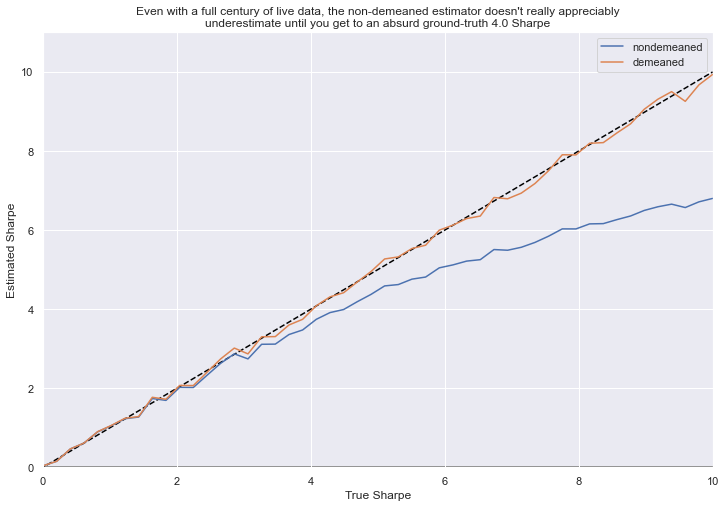

In [62]:
def _sim(true_sharpe: float=0):
    r = ff._sim_r(ann_sharpe=true_sharpe)
    est_sharpe = fc.get_series([
        ("nondemeaned", ff._get_est_sharpe_of_r(r=r)),
        ("demeaned", ff._get_est_sharpe_of_r(r=r, de_avg_kind="mean"))
    ])
    return est_sharpe

def sim():
    est_sharpe = pd.DataFrame({true_sharpe: _sim(true_sharpe=true_sharpe) for true_sharpe in np.linspace(0,10)}).T
    return est_sharpe

def plot_sim():
    np.random.seed(42)
    est_sharpe = sim()
    ax = fc.get_y_equals_x_plot_base(lim=10)
    fc.plot(
        est_sharpe,
        xlabel="True Sharpe",
        ylabel="Estimated Sharpe",
        title="Even with a full century of live data, the non-demeaned estimator doesn't really appreciably\n" + \
            "underestimate until you get to an absurd ground-truth 4.0 Sharpe",
        ax=ax,
        # override from the ax
        ylim_bottom=0
    )

plot_sim()